In [1]:
%load_ext autoreload
%autoreload 2

In [164]:
import json
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import os
import pandas as pd
import torch
import torch.nn.functional as F

from glob import glob
from mlflow.tracking import MlflowClient
from PIL import Image, ImageDraw
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import (
    default_data_collator,
    ViTForImageClassification,
    ViTFeatureExtractor,
    ViTImageProcessor,
    ViTModel
)
from typing import List

In [18]:
# Lets check if our files only have one bounding box per image
data_dir = "../data/*/*/labels/*"
label_files = glob(data_dir)
suspicious_files = []
for label_path in tqdm(label_files):
    with open(label_path, "r") as f:
        content = f.read()
    if len(content.strip().split("\n")) > 1:
        suspicious_files.append(label_path)

  0%|          | 0/5249 [00:00<?, ?it/s]

In [37]:
# within those files check if there are some samples with different kinds of tumor
multilabel_occurrence = 0
for file_path in tqdm(suspicious_files):
    with open(file_path, "r") as f:
        content = f.read()
    bboxes = content.strip().split("\n")
    labels = set(line.split()[0] for line in bboxes)
    if len(labels) > 1:
        multilabel_occurrence += 1

  0%|          | 0/549 [00:00<?, ?it/s]

In [30]:
print(f"We have {multilabel_occurrence}. multilabeled files")
print(f"Which is {multilabel_occurrence * 100. / len(label_files):.2f}% of all files")

We have 257. multilabeled files
Which is 4.90% of all files


In [38]:
content

'1 0.674805 0.448242 0.181641 0.134766\n1 0.592773 0.536133 0.072266 0.048828\n3 0.514648 0.623047 0.087891 0.046875\n'

In [51]:
class_names = ['Glioma', 'Meningioma', 'Pituitary'] # No tumor should not have any bboxes

def load_image(image_path: str) -> Image:
    return Image.open(image_path).convert("RGB")

def load_labels(label_path: str) -> List[str]:
    with open(label_path, 'r') as file:
        labels = []
        for line in file:
            parts = line.strip().split()
            class_id = int(parts[0])
            bbox = [float(part) for part in parts[1:]]
            labels.append((class_id, bbox))
    return labels

def check_bounding_boxes(base_dir):
    invalid_boxes = []
    for class_dir in class_names:
        image_dir = os.path.join(base_dir, class_dir, 'images')
        label_dir = os.path.join(base_dir, class_dir, 'labels')
        
        for image_file in tqdm(os.listdir(image_dir)):
            if image_file.startswith("."):
                continue
            image_path = os.path.join(image_dir, image_file)
            label_path = os.path.join(label_dir, image_file.replace('.jpg', '.txt'))
            
            image = load_image(image_path)
            image_width, image_height = image.size
            labels = load_labels(label_path)
            
            for class_id, bbox in labels:
                x_center, y_center, width, height = bbox
                x_min = (x_center - width / 2) * image_width
                y_min = (y_center - height / 2) * image_height
                x_max = (x_center + width / 2) * image_width
                y_max = (y_center + height / 2) * image_height
                
                if x_min < 0 or y_min < 0 or x_max > image_width or y_max > image_height or width <= 0 or height <= 0:
                    invalid_boxes.append((class_dir, image_file, class_id, bbox))
    
    return invalid_boxes

# Specify the base directories
train_base_dir = '../data/Train'
val_base_dir = '../data/Val'

# Check bounding boxes for training and validation sets
train_invalid_boxes = check_bounding_boxes(train_base_dir)
val_invalid_boxes = check_bounding_boxes(val_base_dir)

print(f'Invalid bounding boxes in training set: {train_invalid_boxes}')
print(f'Invalid bounding boxes in validation set: {val_invalid_boxes}')

  0%|          | 0/1153 [00:00<?, ?it/s]

  0%|          | 0/1449 [00:00<?, ?it/s]

  0%|          | 0/1424 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

Invalid bounding boxes in training set: []
Invalid bounding boxes in validation set: []


In [50]:
# Perfect! looks like we're set! 

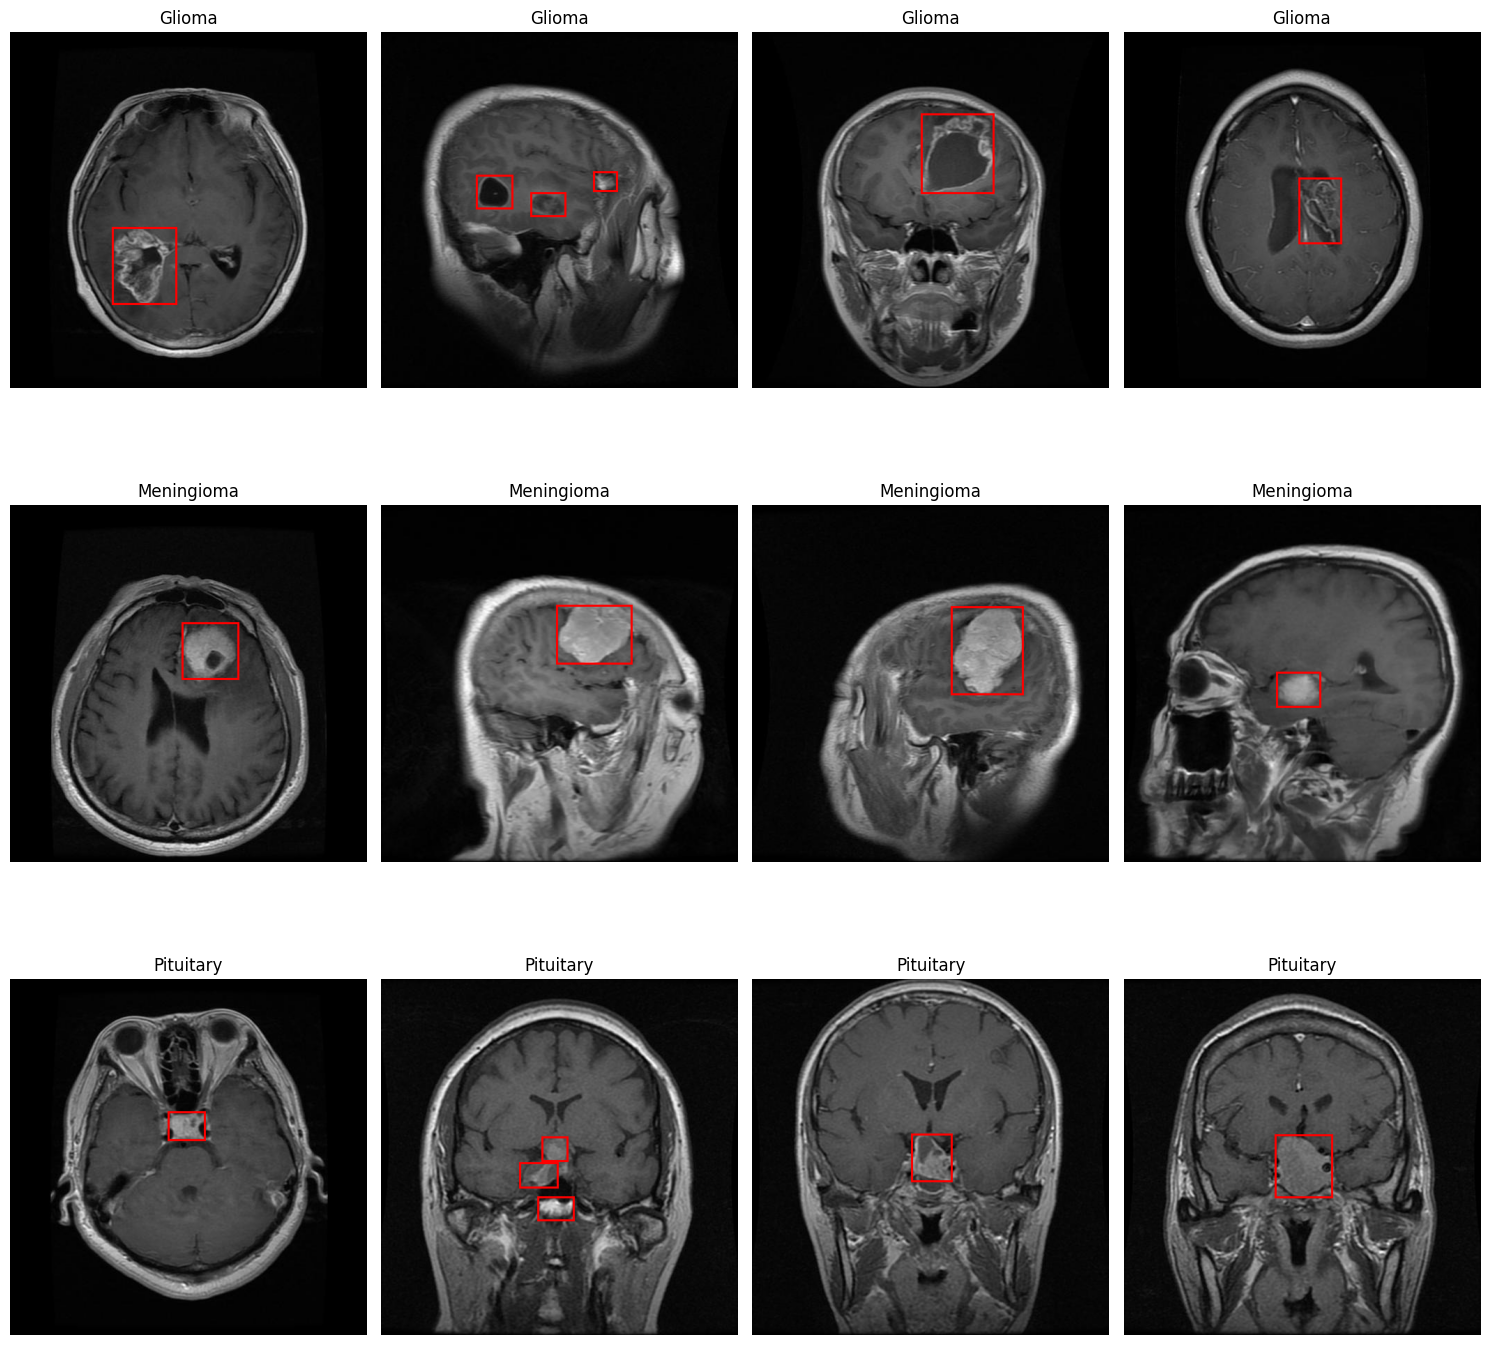

In [54]:
def plot_image_grid(base_dir, class_names, num_images_per_class=4):
    class_images = {class_name: [] for class_name in class_names}

    for class_name in class_names:
        image_dir = os.path.join(base_dir, class_name, 'images')
        label_dir = os.path.join(base_dir, class_name, 'labels')

        for image_file in os.listdir(image_dir):
            if len(class_images[class_name]) < num_images_per_class:
                image_path = os.path.join(image_dir, image_file)
                label_path = os.path.join(label_dir, image_file.replace('.jpg', '.txt'))
                image = load_image(image_path)
                labels = load_labels(label_path)
                
                image_width, image_height = image.size
                
                for class_id, bbox in labels:
                    x_center, y_center, width, height = bbox
                    x_min = (x_center - width / 2) * image_width
                    y_min = (y_center - height / 2) * image_height
                    x_max = (x_center + width / 2) * image_width
                    y_max = (y_center + height / 2) * image_height
                    bbox = [x_min, y_min, x_max, y_max]
                    draw = ImageDraw.Draw(image)
                    draw.rectangle(bbox, outline="red", width=3)

                class_images[class_name].append(image)
            if all(len(images) >= num_images_per_class for images in class_images.values()):
                break

    fig, axs = plt.subplots(len(class_names), num_images_per_class, figsize=(15, 15))
    for class_id, class_name in enumerate(class_names):
        for i, image in enumerate(class_images[class_name]):
            axs[class_id, i].imshow(image)
            axs[class_id, i].set_title(f'{class_name}')
            axs[class_id, i].axis('off')
    
    plt.tight_layout()
    plt.show()


# Visualize a grid of images for each class
plot_image_grid(train_base_dir, class_names, num_images_per_class=4)

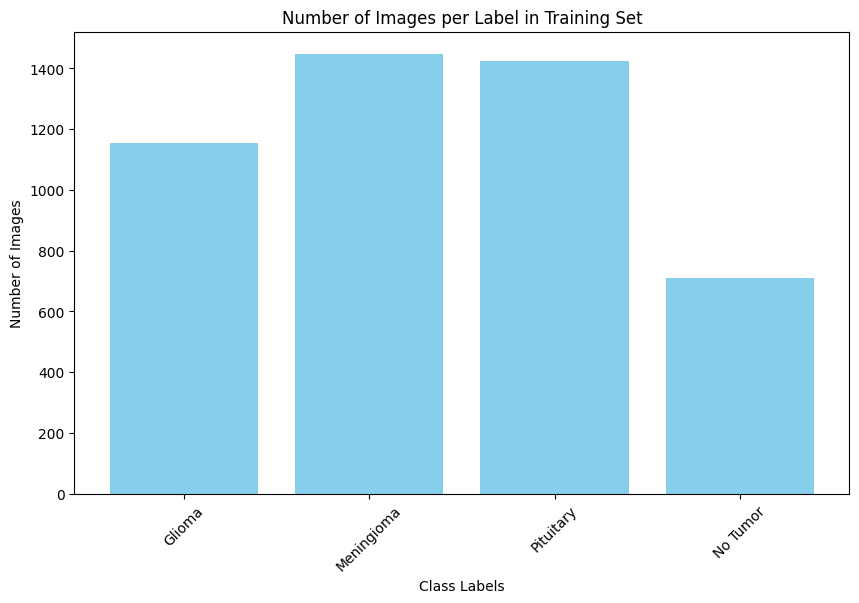

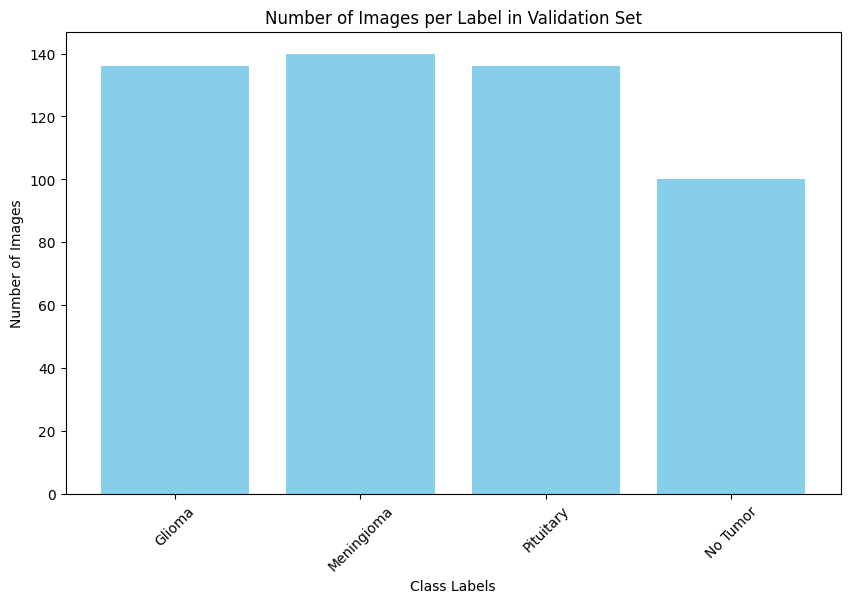

In [56]:
def count_images_per_label(base_dir, class_names):
    label_counts = {class_name: 0 for class_name in class_names}

    for class_name in class_names + ["No Tumor"]:
        image_dir = os.path.join(base_dir, class_name, 'images')
        label_counts[class_name] = len(os.listdir(image_dir))

    return label_counts

def plot_label_distribution(label_counts, title):
    labels = list(label_counts.keys())
    counts = list(label_counts.values())

    plt.figure(figsize=(10, 6))
    plt.bar(labels, counts, color='skyblue')
    plt.xlabel('Class Labels')
    plt.ylabel('Number of Images')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

# Count images per label for training and validation sets
train_label_counts = count_images_per_label(train_base_dir, class_names)
val_label_counts = count_images_per_label(val_base_dir, class_names)

# Plot the label distributions
plot_label_distribution(train_label_counts, 'Number of Images per Label in Training Set')
plot_label_distribution(val_label_counts, 'Number of Images per Label in Validation Set')

In [57]:
# Training data is slightly imbalanced but I will not address it directly. Instead I'll use focal loss in order to 
# focus on misclassified data. Even thought there's less 'No Tumor' samples, our model might handle it quite well

In [74]:
with open("../infrastructure/terraform_env.json", "r") as f:
    config = json.load(f)

In [75]:
MLFLOW_TRACKING_URI = f"postgresql://{config.get('RDS_USERNAME')}:{config.get('RDS_PASSWORD')}@{config.get('RDS_ENDPOINT')}/{config.get('RDS_DB_NAME')}"
MLFLOW_S3_BUCKET = config.get('SAVE_BUCKET')

In [77]:
# Set the tracking URI to the RDS PostgreSQL instance created with terraform
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

In [78]:
# Set the artifact location to the S3 bucket created with terraform
artifact_location = f"s3://{MLFLOW_S3_BUCKET}/mlflow-artifacts"

In [79]:
artifact_location

's3://dev-brain-tumor-detection-model-storage-bucket/mlflow-artifacts'

In [80]:
client = MlflowClient()
mlflow.create_experiment('my_test_experiment', artifact_location=artifact_location)

2024/08/01 20:48:30 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2024/08/01 20:48:31 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl PostgresqlImpl.
INFO  [alembic.runtime.migration] Will assume transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

'1'

In [230]:
class MultiLabelDataset(Dataset):
    def __init__(self, root_dir: str, transform):
        """
        Args:
            root_dir (string): Directory with all the images and labels.
            transform (callable): Transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        
        self.image_dir = os.path.join(root_dir, "*", "images")
        self.label_dir = os.path.join(root_dir, "*", "labels")

        all_images = glob(os.path.join(self.image_dir, "*"))
        self.image_names = sorted(all_images)

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_path = self.image_names[idx]
        image = Image.open(img_path).convert("RGB")
        
        label_path = self.image_names[idx].replace("images", "labels").replace('.jpg', '.txt')
        bboxes = []
        labels = []
        label = torch.Tensor([0, 0, 0, 0])
        with open(label_path, 'r') as file:
            for line in file:
                parts = line.strip().split()
                curr_label = int(parts[0])
                label[curr_label] = 1
                labels.append(curr_label)
                bboxes.append([float(parts[1]), float(parts[2]), float(parts[3]), float(parts[4])])
        
        bboxes = torch.tensor(bboxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)
        
        image = self.transform(image, return_tensors="pt")
        image["pixel_values"] = image["pixel_values"][0]
        #image["bboxes"] = bboxes
        #image["labels_bboxes"] = labels
        image["labels"] = label

        return image

# Example usage:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])
feature_extractor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

train_dataset = MultiLabelDataset(root_dir='../data/Train', transform=feature_extractor)
val_dataset = MultiLabelDataset(root_dir='../data/Val', transform=feature_extractor)

In [124]:
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k", num_labels=3)
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [210]:
class TumorModelMultiLabelClassifier(nn.Module):

    def __init__(self, num_classes):
        super(TumorModelMultiLabelClassifier, self).__init__()
        self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
        self.classifier = nn.Linear(self.vit.config.hidden_size, num_classes)

    def forward(self, pixel_values):
        outputs = self.vit(pixel_values=pixel_values)
        pooled_output = outputs.pooler_output
        logits = self.classifier(pooled_output)
        return logits

In [161]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return F_loss.mean()

class CombinedLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(CombinedLoss, self).__init__()
        self.focal_loss = FocalLoss(alpha, gamma)

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets)
        F_loss = self.focal_loss(inputs, targets)
        return BCE_loss + F_loss

In [231]:
train_dataset = MultiLabelDataset(root_dir='../data/Train', transform=feature_extractor)
dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=default_data_collator)

In [232]:
for i, batch in enumerate(dataloader):
    if i == 5:
        break
i

5

In [182]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS device is available.")
else:
    device = torch.device("cpu")
    print("MPS device is not available, using CPU.")

MPS device is available.


In [236]:
# Initialize the model, loss function, and optimizer
model = TumorModelMultiLabelClassifier(num_classes=4)
model = model.to(device)

# Freeze all layers except the classifier
for param in model.vit.parameters():
    param.requires_grad = False

loss_fn = CombinedLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=1e-4)

# Training loop
num_epochs = 10
model.train()
for epoch in range(num_epochs):
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}", leave=False)
    for batch in progress_bar:
        pixel_values = batch['pixel_values'].to(device)
        labels = batch['labels'].to(device)
        optimizer.zero_grad()
        outputs = model(pixel_values=pixel_values)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        progress_bar.set_postfix(loss=loss.item())
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}")

Epoch 1/10:   0%|          | 0/4737 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [251]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

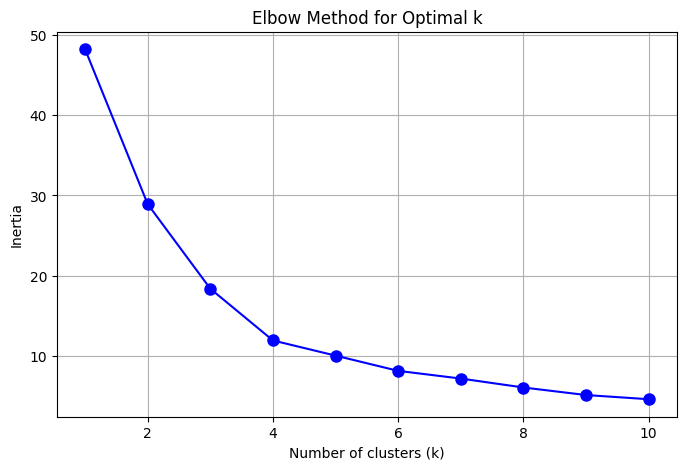

In [254]:
# Generate some example data
X = np.random.rand(300, 2)

# Compute inertia for different values of k
inertia = []
clusters = range(1, 11)
for cluster in clusters:
    kmeans = KMeans(cluster, random_state=42).fit(X)
    inertia.append(kmeans.inertia_)

# Plot the inertia values
plt.figure(figsize=(8, 5))
plt.plot(clusters, inertia, 'bo-', markersize=8)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

Cluster Centers:
 [[0.73497277 0.24376729]
 [0.7532923  0.74513431]
 [0.20966108 0.26230114]
 [0.26008147 0.71884973]]


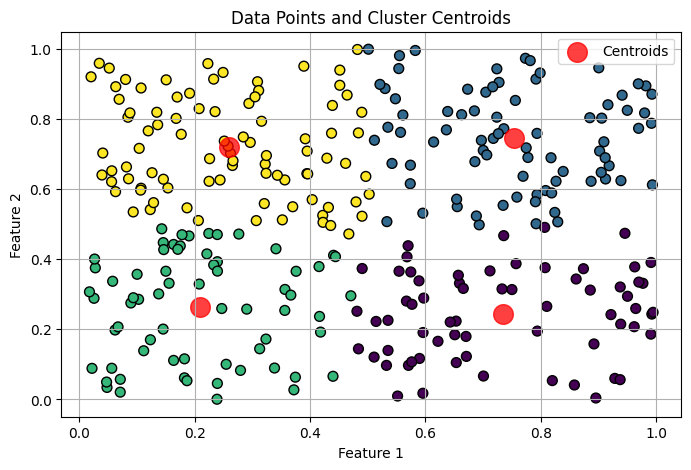

In [255]:
# Optimal number of clusters (assumed to be 4 from the elbow method)
optimal_k = 4

# Fit the final K-means model
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42).fit(X)

# Predict the cluster labels
cluster_labels = final_kmeans.labels_

# Cluster centers
cluster_centers = final_kmeans.cluster_centers_

# Print the cluster centers
print("Cluster Centers:\n", cluster_centers)

# Plot the clustered data
plt.figure(figsize=(8, 5))
plt.scatter(X[:, 0], X[:, 1], c=cluster_labels, cmap='viridis', marker='o', edgecolor='k', s=50)
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', s=200, alpha=0.75, label='Centroids')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Data Points and Cluster Centroids')
plt.legend()
plt.grid(True)
plt.show()